In [1]:
import sys
import os

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.cluster as hpacl  # Now this should work
import hpa.util as hpau  # Now this should work
import hpa.plots as hpapl

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import gsd.hoomd 
from MDAnalysis.analysis import distances



In [3]:
path_200 = '/localscratch/zippoema/project_ness/simulations/200-tdp43_CAL3/'
path_work = '/localscratch/zippoema/working_dir/'
path_an_200 = '/localscratch/zippoema/project_ness/analysis/200-tdp43_CAL3/'
path_an_dp = '/localscratch/zippoema/project_ness/analysis/condensate_dephospho/'
path_dp = '/localscratch/zippoema/project_ness/simulations/condensate_dephospho/'
path_ness = '/localscratch/zippoema/project_ness/simulations/simple-ness_CAL3/'
path_fix = '/localscratch/zippoema/project_ness/simulations/ness_1-ck1d_1-pp3/'

### Center trajectory

In [6]:
for i in range(1,11):
    hpau.center_trajectory(path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_resize_end.gsd', path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered1.gsd')
    hpau.center_trajectory(path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered1.gsd', path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered.gsd')
    hpau.center_trajectory(path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered.gsd', path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered1.gsd')
    hpau.center_trajectory(path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered1.gsd', path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered.gsd')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


In [7]:
!rm /localscratch/zippoema/project_ness/simulations/sim_200-tdp43-lcd_CAL3/therm*_200-tdp43-lcd_CAL3_centered1.gsd

In [11]:
for i in range(1,6):
    hpau.process_trajectory(path_dp+f'sim_200-tdp43-lcd-2800pser_5-pp3/sim{i}_200-tdp43-lcd-2800pser_5-com-pp3_CAL3_dump.gsd', 
                            path_an_dp+f'sim_200-tdp43-lcd-2800pser_5-pp3/sim{i}_200-tdp43-lcd-2800pser_5-com-pp3_CAL3_dump_processed.gsd', 
                            diss_time=50000, center_id=30800)


100%|███████████████████████████████████████| 2500/2500 [02:40<00:00, 15.60it/s]


### Modify particle positions

In [40]:
for i in [1,22,21]:
    frame_compl = gsd.hoomd.open(path_work+f'benchmark_local/sim_100-tdp43-lcd_1-ck1d-open/sim{i}_100-tdp43-lcd_1-com-ck1d-open_CAL3_end.gsd', mode='rb')[0]
    frame_pos = gsd.hoomd.open(path_work+f'benchmark_local/sim_100-tdp43-lcd_1-ck1d-open/sim_100-tdp43-lcd_CAL3_start.gsd', mode='rb')[0]
    hpau.modify_particles_position(frame_compl, frame_pos, 
                                   save=path_work+f'benchmark_local/sim_100-tdp43-lcd_1-ck1d-open/sim{i}_100-tdp43-lcd_1-com-ck1d-open_CAL3_start.gsd')

In [21]:
snap = gsd.hoomd.open(path_200+f'sim_200-tdp43-lcd_5-ck1d-open_5-pp3/sim1_200-tdp43-lcd_5-com-ck1d-open_5-com-pp3_CAL3_dump.gsd', mode='rb')[1000]
with gsd.hoomd.open(path_work+f'init_conf_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd_5-com-ck1d-open_5-com-pp3_CAL3_snap1000.gsd', mode='wb') as f:
    f.append(snap)


In [67]:
for i in [2500]:
    frame_compl = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_lattice.gsd', mode='rb')[0]
    frame_pos = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_5-ck1d-open_hps-cp-r30.gsd', mode='rb')[0]
    hpau.modify_particles_position(frame_compl, frame_pos, id_end_compl=30800, id_end_pos=30800,
                                   save=path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_2-com-ck1d-open_10-com-pp3_CAL3_shorttherm_start.gsd')

In [68]:
for i in [2500]:
    frame_compl = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_2-com-ck1d-open_10-com-pp3_CAL3_shorttherm_start.gsd', mode='rb')[0]
    frame_pos = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_5-ck1d-open_hps-cp-r30.gsd', mode='rb')[0]
    hpau.modify_particles_typeid(frame_compl, frame_pos, id_end_compl=30800, id_end_tid=30800,
                                   save=path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_2-com-ck1d-open_10-com-pp3_CAL3_shorttherm_start.gsd')

## Create distance trajectory

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/coordinates/GSD.py:263: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = gsd.fl.open(name=name,
100%|███████████████████████████████████████████████████████████| 100000/100000 [00:34<00:00, 2916.73it/s]


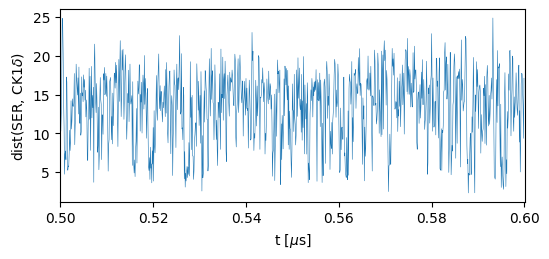

In [4]:
for s in range(10,11):
    d = hpau.create_distance_file(path_ness+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_dump.gsd', 
                                         id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    np.savetxt(path_ness+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2988.45it/s]


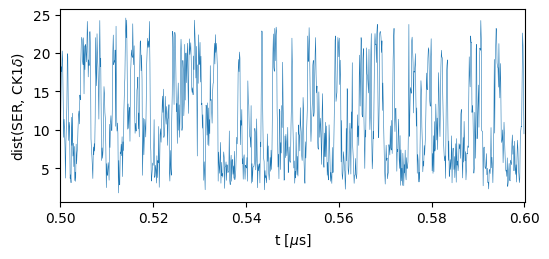

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2972.08it/s]


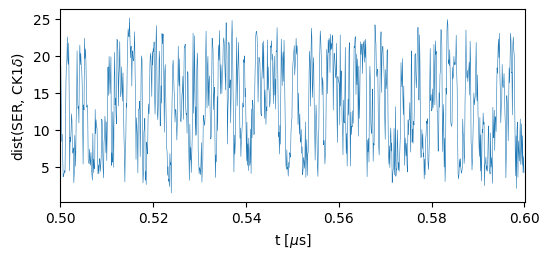

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2972.49it/s]


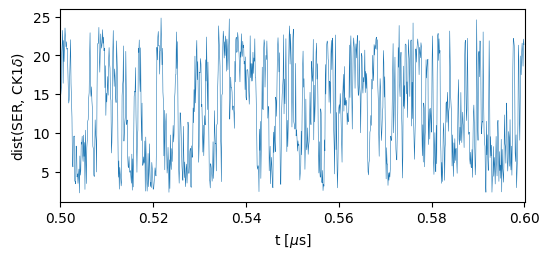

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2979.08it/s]


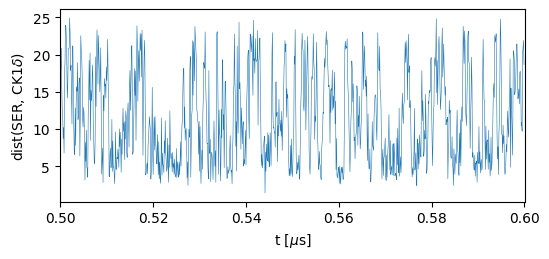

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2884.11it/s]


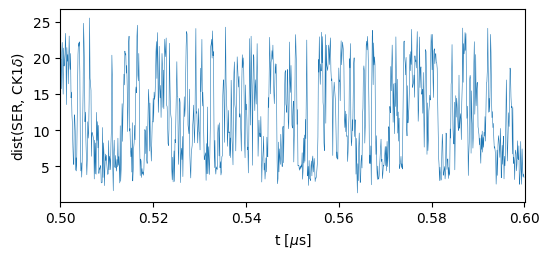

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2991.92it/s]


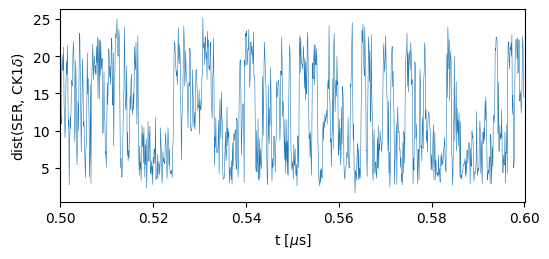

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2977.41it/s]


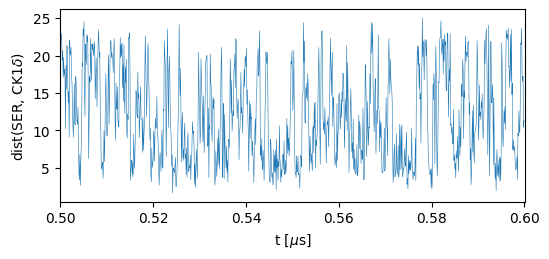

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 2991.03it/s]


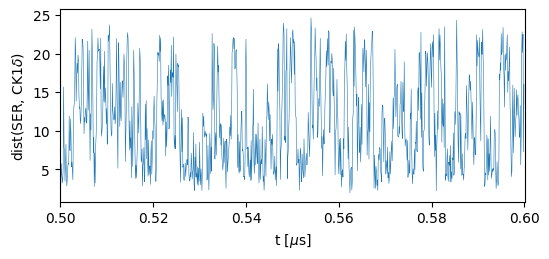

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 3018.83it/s]


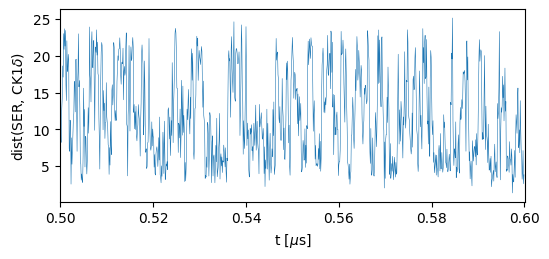

100%|█████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 3010.17it/s]


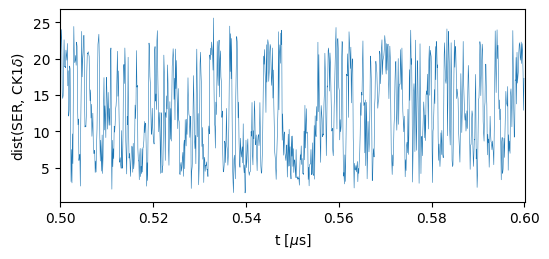

In [9]:
for s in range(1,11):
    d = hpau.create_distance_file(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_dump.gsd', 
                                         id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    tmp = hpau.create_distance_file(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_dump.gsd', 
                                         id1=[445+92,445+94,445+120,445+152,445+283], id2=[i for i in range(154)], mean1=True, therm=0)
    d = np.append(d, tmp, axis=1)
    np.savetxt(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)